# 📬 Spam Message Classifier using NLP & Logistic Regression


Welcome to the **Spam Message Classification** project! This notebook walks through the entire lifecycle of building a **Logistic Regression-based spam detection model** using Natural Language Processing (NLP).  

### 🔍 Problem Statement
Automatically classify a message as `spam` or `ham` (not spam) based on its text content.

### 💡 Key Features
- Uses **Logistic Regression** with **TF-IDF Vectorization**
- Cleaned with **NLTK** lemmatization and POS tagging
- Evaluated using **confusion matrix**, **classification report**, and **ROC-AUC**
- Visual insights for easy understanding


In [1]:
import pandas as pd
import pickle
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
import string

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/C0MPL3X/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/C0MPL3X/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/C0MPL3X/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/C0MPL3X/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 📂 Load Datasets

In [2]:

main_df = pd.read_csv("../../dataset/dataset.csv", encoding="latin-1")
extra_df1 = pd.read_csv("../../dataset/spam.csv", encoding="latin-1")
extra_df2 = pd.read_csv("../../dataset/synthetic_spam_ham_dataset.csv")

main_df.columns = ['label', 'message']
extra_df1 = extra_df1.iloc[:, :2]
extra_df1.columns = ['label', 'message']
extra_df1 = extra_df1[extra_df1['label'].isin(['ham', 'spam'])]

combined_df = pd.concat([main_df, extra_df1, extra_df2], ignore_index=True)
combined_df.dropna(inplace=True)
combined_df['label'] = combined_df['label'].str.lower().map({'ham': 0, 'spam': 1})
combined_df = combined_df[combined_df['label'].isin([0, 1])]
combined_df.head()

,label,message
0,1,naturally irresistible your corporate identity...
1,1,the stock trading gunslinger fanny is merrill ...
2,1,unbelievable new homes made easy im wanting to...
3,1,4 color printing special request additional in...
4,1,do not have money get software cds from here s...


# Shape of Data


In [3]:
print("Input data has {} rows and {} columns".format(len(combined_df),len(combined_df.columns)))

Input data has 28919 rows and 2 columns


## How many spam/ham are there


In [6]:
print("Out of {} rows, {} are spam. {} are ham".format(len(combined_df),len(combined_df[combined_df['label']==1]), len(combined_df[combined_df['label']==0])))

Out of 28919 rows, 7958 are spam. 20961 are ham


## How much missing data is there


In [7]:
print("Number of null in label: {}".format(combined_df['label'].isnull().sum()))

print("Number of null in text: {}".format(combined_df['message'].isnull().sum()))

Number of null in label: 0
Number of null in text: 0


## 🧹 Text Preprocessing Functions

In [8]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    tagged = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(t, get_wordnet_pos(pos)) for t, pos in tagged]
    return ' '.join(lemmatized)


## 📂 Preprocess Datasets

In [9]:
combined_df['message'] = combined_df['message'].apply(preprocess_text)
combined_df = shuffle(combined_df, random_state=42)
combined_df.head()

,label,message
12788,0,eatin lunch
1388,0,program question gwyn program contract mean en...
27759,1,congratulation amazon gift card claim http
12230,0,hi dear saw dear happy battery low
27993,0,let finalize ppt tonight


## 📊 Class Distribution

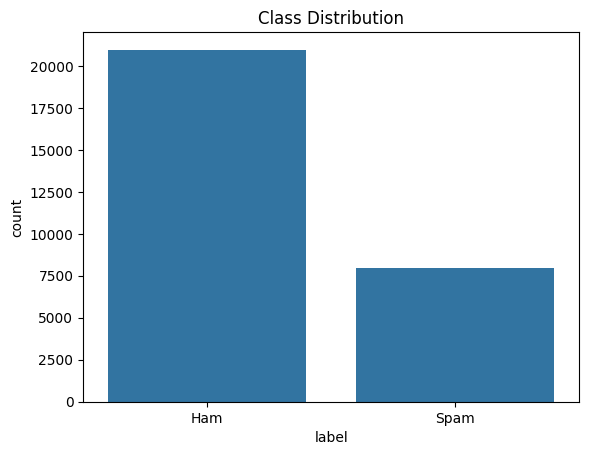

In [10]:

sns.countplot(data=combined_df, x='label')
plt.xticks([0,1], ['Ham', 'Spam'])
plt.title("Class Distribution")
plt.show()


## ✂️ Train-Test Split

In [11]:

X_train, X_test, y_train, y_test = train_test_split(
    combined_df['message'], combined_df['label'], test_size=0.2, random_state=42
)


## 🔠 TF-IDF Vectorization & Model Training

In [12]:

vectorizer = TfidfVectorizer(max_df=0.95, ngram_range=(1, 2), min_df=5)
X_train_vec = vectorizer.fit_transform(X_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


## 📈 Model Evaluation

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      4152
           1       0.93      0.81      0.87      1632

    accuracy                           0.93      5784
   macro avg       0.93      0.89      0.91      5784
weighted avg       0.93      0.93      0.93      5784



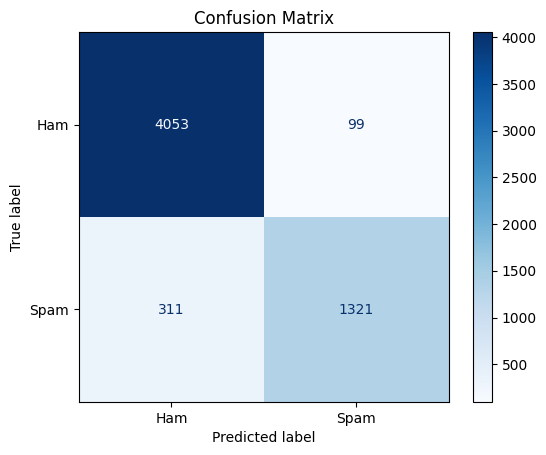

ROC-AUC Score: 0.8928


In [13]:

X_test_vec = vectorizer.transform(X_test)
predictions = model.predict(X_test_vec)

print("Classification Report:\n", classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm, display_labels=["Ham", "Spam"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(y_test, predictions)
print(f"ROC-AUC Score: {roc_auc:.4f}")


## 💾 Save Model and Vectorizer

In [14]:

# with open("spam_classifier.pkl", "wb") as f:
#     pickle.dump(model, f)

# with open("vectorizer.pkl", "wb") as f:
#     pickle.dump(vectorizer, f)

print("✅ Model and vectorizer saved successfully.")


✅ Model and vectorizer saved successfully.
